In [ ]:
import pandas as pd
import numpy as np

trading_instrument = 'al'
dir_data_path ='RESULT_ALL_new'
dir_path = os.path.join(dir_data_path,trading_instrument)
info_file_path =  os.path.join(dir_path,trading_instrument + "_info.csv")

info_data = pd.read_csv(info_file_path, index_col=[0])
# audata = pd.read_csv("RESULT_ALL_new/al/al2103_al2104_final.csv", index_col=[0], parse_dates=[0])
# audata['trading_date'] = pd.to_datetime(audata['trading_date'])
info_data['change_date'] = pd.to_datetime(info_data['change_date'])
info_data

In [ ]:
def get_trading_data(trading_date_now, df_all, history_days):
    res_finding = False
    res_today_df = pd.DataFrame()
    res_history_df = pd.DataFrame()  
    #1.先找出今周数据
    today_data = df_all[(df_all['trading_date'] >= trading_date_now) & (df_all['trading_date'] < (trading_date_now + pd.Timedelta("7 day")))]
    if len(today_data) < 10:
        return res_finding,res_today_df,res_history_df

    res_today_df = today_data
    #2.取出历史数据
    history_date = trading_date_now
    history_data_count = 0
          
    for i in range(0,100):
        history_date = history_date - pd.Timedelta("1 day")
        if history_data_count < history_days:
            history_data = df_all[(df_all['trading_date'] >= history_date) & (df_all['trading_date'] < (history_date + pd.Timedelta("1 day")))]
            if len(history_data) > 10:
                history_data_count += 1
                res_history_df = pd.concat([res_history_df,history_data])
    if history_data_count >= history_days:
        res_finding = True
    return res_finding,res_today_df,res_history_df


import datetime
import statsmodels.api as sm
start_date = datetime.datetime(2020, 5, 1)
end_date = datetime.datetime(2021, 6, 1)
trading_date = start_date

direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []
trading_date_in = ""

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 14
tick_size = 5
K = 0
beta = 0
up_threshold = 0

current_info_index = -1
holding = False
data_all = pd.DataFrame()
test_data = pd.DataFrame()

while trading_date <= end_date:
    trading_date = trading_date + pd.Timedelta("7 day")
    # print(trading_date)
    #1.检查需要的数据
    for i in range(0,len(info_data) - 1):
        if trading_date >= info_data.change_date[i] and trading_date < info_data.change_date[i + 1]:
            if holding == False and current_info_index != i:
                current_info_index = i
                data_all_path = os.path.join(dir_path,info_data.a_id[i] + "_" + info_data.b_id[i] + "_final.csv")
                data_all = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
                data_all['trading_date'] = pd.to_datetime(data_all['trading_date'])
                print(data_all_path)
            elif holding == True and current_info_index != i:
                if trading_date > (info_data.change_date[i] + pd.Timedelta("6 day")):
                    holding = False
                    if direction == 'a-b':
                        single_ret = (Spread2_ask[-1] - enter_record[-1][0])
                    else:
                        single_ret = (enter_record[-1][0] - Spread2_bid[-1])
                    
                    if trading_date_in == test_data.trading_date[-10]:
                        single_cost = cost_rate * (test_data.last_A[-10] + test_data.last_B[-10])
                    else:
                        single_cost = cost_rate * (test_data.last_A[-10] + test_data.last_B[-10]) * 2 
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append((Spread2_ask[-1], ask_price, test_data.index[i],single_ret,single_cost))
                    print('还有持仓，强平',Spread2_ask[-1], ask_price,'ret:',single_ret - single_cost)
                    current_info_index = i
                    data_all_path = os.path.join(dir_path,info_data.a_id[i] + "_" + info_data.b_id[i] + "_final.csv")
                    data_all = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
                    data_all['trading_date'] = pd.to_datetime(data_all['trading_date'])
                    print(data_all_path)
    #有数据再处理
    if len(data_all) > 10:
        res_finding, test_data_temp, df_history_temp = get_trading_data(trading_date,data_all,delta_days)
        if res_finding == True:
            test_data = test_data_temp
            df_history = df_history_temp
            #使用数据的成交价拟合beta
            model = sm.OLS(df_history.last_A, df_history.last_B).fit()
            beta = model.params['last_B']
            eps = df_history.last_A - df_history.last_B * beta #生成拟合后数据

            #根据beta生产对手价的ask和bid序列
            eps2_ask = test_data.bid_A - test_data.ask_B * beta
            eps2_bid = test_data.ask_A - test_data.bid_B * beta
            #生成实际的成交的ask和bid价格（由于实际交易都是1:1）
            Spread2_ask = test_data.bid_A - test_data.ask_B
            Spread2_bid = test_data.ask_A - test_data.bid_B

            print(" ")
            print('test_day:',trading_date)
            print(model.params)

            #进入交易
            #生成交易信号阈值
            # K = 2
            # if up_threshold == 0:
            # up_threshold =  2 * np.std(eps)
            # else:
            #     up_threshold = (up_threshold * 0.5) +  (K * np.std(eps) * 0.5)
            up_threshold = 60
            down_threshold = - up_threshold

            #生成止损信号阈值
            up_threshold_stop = 200#up_threshold * 6
            down_threshold_stop = -up_threshold_stop
            #生成最大亏损信号阈值
            biggest_lost = -200

            #生成平仓信号阈值
            up_close_threshold = 10#up_threshold - 4 * tick_size
            # down_close_threshold = down_threshold + 3 * tick_size
            down_close_threshold = -up_close_threshold

            print('beta:',beta)
            print('阈值：',up_threshold)
            print('止损点：',up_threshold_stop)

            #遍历数据判断交易
            for i, v in enumerate(eps2_ask.values):
                #交易时间点判断:去除开盘前10分钟和收盘前十分钟
                start_time1 = datetime.time(21,10,0) #夜盘开盘
                start_time2 = datetime.time(9,10,0) #早上开盘

                end_time1 = datetime.time(0,50,0) #夜盘收盘
                end_time2 = datetime.time(14,50,0) #下午收盘
                #判断是否在我们规定交易时段
                if (eps2_ask.index[i].time() > start_time1 or eps2_ask.index[i].time() < end_time1) or \
                    (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

                    ask_price = eps2_ask[i] #获取价格
                    bid_price = eps2_bid[i]
                    if not holding:
                        # 判断进场条件
                        if ask_price > up_threshold and stop_event != 'up_stop':
                            holding = True
                            stop_event = "none"
                            direction = 'b-a'
                            trading_date_in = test_data.trading_date[i]
                            print(test_data.index[i],'b-a进场', Spread2_ask[i], ask_price,'--',len(enter_record))
                            #记录进出场信息
                            enter_record.append((Spread2_ask[i], ask_price,test_data.index[i],direction))
                        elif bid_price < down_threshold and stop_event != 'down_stop':
                            holding = True
                            stop_event = "none"
                            direction = 'a-b'
                            trading_date_in = test_data.trading_date[i]
                            print(test_data.index[i],'a-b进场', Spread2_bid[i], bid_price,'--',len(enter_record))
                            enter_record.append((Spread2_bid[i], bid_price,test_data.index[i],direction))
                            
                    elif holding:
                        # 判断离场条件
                        if direction == 'a-b' and ask_price > down_close_threshold:
                            holding = False
                            out_price = Spread2_ask[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (out_price - last_enter_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            out_record.append((Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                            print(test_data.index[i],'a-b出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                            
                            
                        elif direction =='b-a' and bid_price < up_close_threshold:
                            holding = False
                            out_price = Spread2_bid[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (last_enter_price - out_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2       
                            
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            out_record.append((Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                            print(test_data.index[i],'b-a出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)

                        #判断止损条件
                        elif direction == 'a-b' and ask_price < down_threshold_stop:

                            
                            holding = False
                            stop_event = 'down_stop'               
                            out_price = Spread2_ask[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (out_price - last_enter_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 

                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                            print(test_data.index[i],'a-b止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                            
                            
                        elif direction =='b-a' and bid_price > up_threshold_stop:
                            holding = False
                            stop_event = 'up_stop'
                            out_price = Spread2_bid[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (last_enter_price - out_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2        
                            
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            print(test_data.index[i],'b-a止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                            out_record.append(( Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                        else: #判断最大亏损有没有达到阈值
                            if direction == 'a-b':
                                out_price = Spread2_ask[i]
                                last_enter_price = enter_record[-1][0]
                                single_ret = (out_price - last_enter_price)
                                if single_ret < biggest_lost:
                                    holding = False
                                    stop_event = 'down_stop'
                                    if trading_date_in == test_data.trading_date[i]:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                                    else:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 
                                    pure_pnl.append(single_ret)
                                    trading_cost.append(single_cost)
                                    pnl.append(single_ret - single_cost)

                                    print(test_data.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                                    out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                            elif direction =='b-a':
                                out_price = Spread2_bid[i]
                                last_enter_price = enter_record[-1][0]
                                single_ret = (last_enter_price - out_price)
                                if single_ret < biggest_lost:
                                    holding = False
                                    stop_event = 'up_stop'
                                    if trading_date_in == test_data.trading_date[i]:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                                    else:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2         
                                    pure_pnl.append(single_ret)
                                    trading_cost.append(single_cost)
                                    pnl.append(single_ret - single_cost)

                                    print(test_data.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                                    out_record.append((Spread2_bid[i], bid_price, test_data.index[i],single_ret,single_cost))



In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [ ]:
import statsmodels.api as sm
import datetime
holding = False
direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []
trading_date_in = ""

pure_pnl = []
trading_cost = []
pnl = []

cost_rate = 0.5 / 10000
delta_days = 8
K = 0
beta = 0
up_threshold = 0
# data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
#取最近5天数据
for date_index in range(0,len(pd_date_list) - delta_days):

    #根据日期获取拟合数据
    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]
    #使用数据的成交价拟合beta
    model = sm.OLS(data.last_A, data.last_B).fit()
    beta = model.params['last_B']
    eps = data.last_A - data.last_B * beta #生成拟合后数据

    #根据日期获取交易数据       
    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    #根据beta生产对手价的ask和bid序列
    eps2_ask = test_data.bid_A - test_data.ask_B * beta
    eps2_bid = test_data.ask_A - test_data.bid_B * beta
    #生成实际的成交的ask和bid价格（由于实际交易都是1:1）
    Spread2_ask = test_data.bid_A - test_data.ask_B
    Spread2_bid = test_data.ask_A - test_data.bid_B

    print(" ")
    print('test_day:',start_time)
    print(model.params)

    #进入交易
    #生成交易信号阈值
    K = 1
    if up_threshold == 0:
        up_threshold =  np.std(eps)
    else:
        up_threshold = (up_threshold * 0.7) +  (K * np.std(eps) * 0.3)
    # up_threshold = 20
    down_threshold = - up_threshold

    #生成止损信号阈值
    up_threshold_stop = np.std(eps) * 100
    down_threshold_stop = -up_threshold_stop
    #生成最大亏损信号阈值
    biggest_lost = -1000

    #生成平仓信号阈值
    up_close_threshold = up_threshold/2
    down_close_threshold = down_threshold/2

    print('beta:',beta)
    print('阈值：',up_threshold)
    print('止损点：',up_threshold_stop)

    #遍历数据判断交易
    for i, v in enumerate(eps2_ask.values):
        #交易时间点判断:去除开盘前10分钟和收盘前十分钟
        start_time1 = datetime.time(21,10,0) #夜盘开盘
        start_time2 = datetime.time(9,10,0) #早上开盘

        end_time1 = datetime.time(0,50,0) #夜盘收盘
        end_time2 = datetime.time(14,50,0) #下午收盘
        #判断是否在我们规定交易时段
        if (eps2_ask.index[i].time() > start_time1 or eps2_ask.index[i].time() < end_time1) or \
            (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

            ask_price = eps2_ask[i] #获取价格
            bid_price = eps2_bid[i]
            if not holding:
                # 判断进场条件
                if ask_price > up_threshold and stop_event != 'up_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'b-a'
                    trading_date_in = test_data.trading_date[i]
                    print(test_data.index[i],'b-a进场', Spread2_ask[i], ask_price,'--',len(enter_record))
                    #记录进出场信息
                    enter_record.append((Spread2_ask[i], ask_price,test_data.index[i],direction))
                elif bid_price < down_threshold and stop_event != 'down_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'a-b'
                    trading_date_in = test_data.trading_date[i]
                    print(test_data.index[i],'a-b进场', Spread2_bid[i], bid_price,'--',len(enter_record))
                    enter_record.append((Spread2_bid[i], bid_price,test_data.index[i],direction))
                    
            elif holding:
                # 判断离场条件
                if direction == 'a-b' and ask_price > down_close_threshold:
                    holding = False
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append((Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                    print(test_data.index[i],'a-b出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price < up_close_threshold:
                    holding = False
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2       
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append((Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                    print(test_data.index[i],'b-a出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)

                #判断止损条件
                elif direction == 'a-b' and ask_price < down_threshold_stop:
                    holding = False
                    stop_event = 'down_stop'               
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                    print(test_data.index[i],'a-b止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price > up_threshold_stop:
                    holding = False
                    stop_event = 'up_stop'
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2        
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    print(test_data.index[i],'b-a止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                    out_record.append(( Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                else: #判断最大亏损有没有达到阈值
                    if direction == 'a-b':
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'down_stop'
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            print(test_data.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                            out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                    elif direction =='b-a':
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'up_stop'
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2         
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            print(test_data.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                            out_record.append((Spread2_bid[i], bid_price, test_data.index[i],single_ret,single_cost))

            
if holding:
    if direction == 'a-b':
        single_ret = (Spread2_ask[-1] - enter_record[-1][0])
    else:
        single_ret = (enter_record[-1][0] - Spread2_bid[-1])
    
    if trading_date_in == test_data.trading_date[i]:
        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
    else:
        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 
    pure_pnl.append(single_ret)
    trading_cost.append(single_cost)
    pnl.append(single_ret - single_cost)

    out_record.append((Spread2_ask[i], ask_price, test_data.index[i],single_ret,single_cost))
    print('还有持仓，强平',Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)

#做汇总处理，生成交易日志和结果。
df_record = pd.DataFrame()
index_list = []
direction_list = []
in_out_price = []
in_out_eps_price = []
ret_list = []
cost_list = []
pure_ret_list = []
for j in range(0,len(enter_record)):
    #更新index
    index_list.append(enter_record[j][2])
    index_list.append(out_record[j][2])
    #更新方向：
    direction_list.append(enter_record[j][3] + ' in')
    direction_list.append(enter_record[j][3] + ' out')
    #更新进出场价格-原始和eps
    in_out_price.append(enter_record[j][0])
    in_out_price.append(out_record[j][0])

    in_out_eps_price.append(enter_record[j][1])
    in_out_eps_price.append(out_record[j][1])

    #更新成本和收益
    pure_ret_list.append(0) #进场为0
    pure_ret_list.append(out_record[j][3]) #出场记录

    cost_list.append(0) #进场为0
    cost_list.append(out_record[j][4]) #出场记录

    ret_list.append(0) #进场为0
    ret_list.append(out_record[j][3] - out_record[j][4]) #出场记录

#转换为datafram
df_record = data_all.loc[index_list]
df_record['trading_direction'] = direction_list
df_record['in_out_price'] = in_out_price
df_record['in_out_eps_price'] = in_out_eps_price
df_record['pure_return'] = ret_list
df_record['trading cost'] = cost_list
df_record['final return'] = pure_ret_list


In [ ]:
import datetime
start_date = datetime.datetime(2021, 1, 10)
end_date = datetime.datetime(2021, 2, 28)
data_all = audata.loc[audata.trading_date >= start_date]
data_all = data_all.loc[data_all.trading_date < end_date]

#删除为0的行，排除涨跌停导致价格为0
data_all.drop( index = data_all.ask_A[data_all.ask_A == 0].index,inplace = True)
data_all.drop( index = data_all.bid_A[data_all.bid_A == 0].index,inplace = True)
data_all.drop( index = data_all.ask_B[data_all.ask_B == 0].index,inplace = True)
data_all.drop( index = data_all.bid_B[data_all.bid_B == 0].index,inplace = True)

#获取到交易日，后面根据交易日做循环
pd_date_list = pd.DataFrame()
pd_date_list['time_stamp'] = data_all['trading_date']
# normalize, count values, convert to dataframe
pd_date_list = pd_date_list['time_stamp'].dt.normalize().value_counts().to_frame().reset_index()
# rename columns
pd_date_list.columns = ['time_stamp', 'count']
pd_date_list.sort_values(by='time_stamp',inplace=True)
pd_date_list = pd_date_list.reset_index()
pd_date_list.drop(columns='index',inplace=True)
pd_date_list


In [ ]:
import statsmodels.api as sm
import datetime
holding = False
direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []
trading_date_in = ""

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 5
K = 0
beta = 0
df_data_after_beta = pd.DataFrame()
#取最近5天数据
for date_index in range(0,len(pd_date_list) - delta_days):

    #根据日期获取拟合数据
    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]
    #使用数据的成交价拟合beta
    model = sm.OLS(data.last_A, data.last_B).fit()
    beta = model.params['last_B']
    eps = data.last_A - data.last_B * beta #生成拟合后数据

    #根据日期获取交易数据       
    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    #根据beta生产对手价的ask和bid序列
    eps2_ask = test_data.bid_A - test_data.ask_B * beta
    eps2_bid = test_data.ask_A - test_data.bid_B * beta
    eps2_last = test_data.last_A - test_data.last_B * beta
    df_data_after_beta = pd.concat([df_data_after_beta,eps2_last])
    print(np.std(eps2_last))

    

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [ ]:
df_data_after_beta

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df_data_after_beta,'.', label='spred')
plt.plot(data_all["spd_last"],'.', label='real')
plt.legend()
plt.show()

In [ ]:
df_record

In [13]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import datetime


class cointegration_analysis:
    # init
    def __init__(self, series_A, series_B):
        self.data_A = series_A
        self.data_B = series_B
        self.coin_series = {}
        self.is_co_int = False
        self.std_value = 0
        self.beta = 1

    def ADF_check(self, check_series):
        if len(check_series) == 0:
            print("ADF CHECK 请输入正确序列！！")
            return False, []
        adf = ts.adfuller(check_series)
        if adf[1] < 0.1:  # 小于指定值，证明显著性可以通过检验
            return True, adf
        else:
            return False, adf

    def cointegration_check(self):
        # step2 使用OLS 计算残差序列，验证是否平稳
        model = sm.OLS(self.data_A, self.data_B).fit()
        self.beta = model.params[self.data_B.name]
        self.coin_series = self.data_A - (self.data_B * self.beta)
        res = self.ADF_check(self.coin_series)
        self.is_co_int = res[0]
        self.std_value = np.std(self.coin_series)
        return self.is_co_int, self.std_value

    def run(self):
        return self.cointegration_check()

    def get_result(self):
        return self.is_co_int, self.coin_series, self.std_value, self.beta

    def ecm_analysis(self):
        pass


def get_instrument_info(instrument_id, input_path):

    dir_path = os.path.join(input_path, instrument_id)
    info_file_path = os.path.join(dir_path, trading_instrument + "_info.csv")
    info_data = pd.read_csv(info_file_path, index_col=[0])
    if len(info_data) > 0:
        info_data["change_date"] = pd.to_datetime(info_data["change_date"])
        return info_data
    else:
        print("input err!!")
        return info_data


def get_trade_data(trading_date_start, trading_date_end, df_all):
    return df_all[(df_all["trading_date"] >= trading_date_start)
                  & (df_all["trading_date"] < trading_date_end)]


def get_trade_data_by_workdays(trading_date, direction, days, df_all):
    # 取出数据，包含当天数据 direction 大于0往后，小于等于0往前
    find_date = trading_date
    find_data_count = 0
    res_finding = False
    res_df = pd.DataFrame()

    for i in range(0, 60):
        if find_data_count < days:
            temp_data = df_all[(df_all["trading_date"] >= find_date) & (
                df_all["trading_date"] < (find_date + pd.Timedelta("1 day")))]

            if len(temp_data) > 10:
                find_data_count += 1
                res_df = pd.concat([res_df, temp_data])
        if direction > 0:
            find_date = find_date + pd.Timedelta("1 day")
        else:
            find_date = find_date - pd.Timedelta("1 day")

    if find_data_count >= days:
        res_finding = True
    return res_finding, find_data_count, res_df


class trading_process():
    def __init__(self,tick_size,single_trading_cost):
        #交易状态参数
        self.direction = None  # "a-b", "b-a"
        self.stop_event = "none"
        self.holding = False
        self.trading_index = 0
        self.data_size = 0
        #结果记录参数
        self.enter_record = []
        self.out_record = []
        self.pnl_res = []
        #交易参数
        self.single_cost = single_trading_cost 
        self.open_threshold = None
        self.close_threshold = None
        self.open_threshold2 = None
        self.close_threshold2 = None
        self.training_data_std = None
        self.biggest_lost = None
        self.df_orignal = pd.DataFrame()
        self.df_processed = pd.DataFrame()
        #产品信息参数
        self.tick_size = tick_size
        self.beta = 1


    def append(self, trading_df):
        self.df_orignal = pd.concat([self.df_orignal,trading_df])    
        temp = pd.DataFrame()
        temp['ask_price_eps'] = trading_df.bid_A - trading_df.ask_B * self.beta
        temp['bid_price_eps'] = trading_df.ask_A - trading_df.bid_B * self.beta
        temp['ask_price'] = trading_df.bid_A - trading_df.ask_B
        temp['bid_price'] = trading_df.ask_A - trading_df.bid_B
        temp['trading_date'] = trading_df.trading_date
        self.df_processed = pd.concat([self.df_processed,temp])
        self.data_size = len(self.df_processed)

    def set_parameters(self, spd_beta, spd_open_thro, spd_close_thro, spd_biggest_lost = None, spd_open_thro2 = None, spd_close_thro2 = None):
        self.beta = spd_beta
        self.open_threshold = spd_open_thro
        self.close_threshold = spd_close_thro
        self.open_threshold2 = spd_open_thro2
        self.close_threshold2 = spd_close_thro2
        self.biggest_lost = spd_biggest_lost

    def trading_run(self, open_enable = True):
        start_index = self.trading_index
        self.trading_index = self.data_size
        for idx in range(start_index, self.data_size):
            ask_price = self.df_processed.ask_price_eps[idx] #获取价格
            bid_price = self.df_processed.bid_price_eps[idx]
            if (self.holding == False) and (open_enable == True):
                # 判断进场条件
                if ask_price > self.open_threshold and self.stop_event != 'up_stop' :
                    self.holding = True
                    self.stop_event = "none"
                    self.direction = 'b-a'
                    #记录进场信息
                    print(self.df_processed.index[idx],'b-a进场', self.df_processed.ask_price[idx], ask_price,' count',len(self.enter_record))
                    self.enter_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx], ask_price, self.df_processed.ask_price[idx],self.direction])
                elif bid_price < -self.open_threshold and self.stop_event != 'down_stop':
                    self.holding = True
                    self.stop_event = "none"
                    self.direction = 'a-b'
                    #记录进场信息
                    print(self.df_processed.index[idx],'a-b进场', self.df_processed.bid_price[idx], bid_price,' count',len(self.enter_record))
                    self.enter_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx], bid_price, self.df_processed.bid_price[idx],self.direction])
            elif(self.holding == True):
                #出场判断，正常出场和止损出场
                # 正常离场
                if self.direction == 'a-b' and ask_price > -self.close_threshold:
                    self.holding = False
                    #计算收益
                    out_price = self.df_processed.ask_price[idx]
                    last_enter_price = self.enter_record[-1][4]
                    single_ret = (out_price - last_enter_price)
                    #判断交易日计算手续费
                    if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                        single_cost = self.single_cost
                    else:
                        single_cost = self.single_cost * 2
                    self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                    self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                            ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                    print(self.df_processed.index[idx],'a-b出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost)    
                elif self.direction =='b-a' and bid_price < self.close_threshold:
                    self.holding = False
                    #计算收益
                    out_price = self.df_processed.bid_price[idx]
                    last_enter_price = self.enter_record[-1][4]
                    single_ret = (last_enter_price - out_price)
                    #判断交易日计算手续费
                    if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                        single_cost = self.single_cost
                    else:
                        single_cost = self.single_cost * 2
                    self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                    self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                            bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                    print(self.df_processed.index[idx],'b-a出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)
                elif self.biggest_lost is not None:
                    #判断是否满足强制离场的条件-止损值
                    if self.direction == 'a-b':
                        #计算实时收益
                        out_price = self.df_processed.ask_price[idx]
                        last_enter_price = self.enter_record[-1][4]
                        single_ret = (out_price - last_enter_price)                  
                        if single_ret < self.biggest_lost:
                            self.holding = False
                            self.stop_event = 'down_stop'
                            #判断交易日计算手续费
                            if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                                single_cost = self.single_cost
                            else:
                                single_cost = self.single_cost * 2
                            self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                            self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                                    ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                            print(self.df_processed.index[idx],'a-b止损出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost) 
                    elif self.direction =='b-a':
                        #计算实时收益
                        out_price = self.df_processed.bid_price[idx]
                        last_enter_price = self.enter_record[-1][4]
                        single_ret = (last_enter_price - out_price)
                        if single_ret < self.biggest_lost:
                            self.holding = False
                            self.stop_event = 'up_stop'
                            #判断交易日计算手续费
                            if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                                single_cost = self.single_cost
                            else:
                                single_cost = self.single_cost * 2
                            self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                            self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                                    bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                            print(self.df_processed.index[idx],'b-a止损出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)


    def force_close(self):
        idx = self.data_size - 30 #使用收盘前半个小时的价格强制平仓
        ask_price = self.df_processed.ask_price_eps[idx] #获取价格
        bid_price = self.df_processed.bid_price_eps[idx]
        if self.holding:
            # 强制离场
            if self.direction == 'a-b':
                self.holding = False
                #计算收益
                out_price = self.df_processed.ask_price[idx]
                last_enter_price = self.enter_record[-1][4]
                single_ret = (out_price - last_enter_price)
                #判断交易日计算手续费
                if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                    single_cost = self.single_cost
                else:
                    single_cost = self.single_cost * 2
                self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])

                self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                        ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                print(self.df_processed.index[idx],'a-b强制出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost)
            elif self.direction =='b-a':
                self.holding = False
                #计算收益
                out_price = self.df_processed.bid_price[idx]
                last_enter_price = self.enter_record[-1][4]
                single_ret = (last_enter_price - out_price)
                #判断交易日计算手续费-相同交易日只付一次，不同交易日付平仓手续费
                if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                    single_cost = self.single_cost
                else:
                    single_cost = self.single_cost * 2
                self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                        bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                print(self.df_processed.index[idx],'b-a强制出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)





def trading(start_day, end_day, df_all, trading_entity, setting):
    #交易处理函数，轮询时间，生成交易参数回测交易
    print('process:', start_day, 'to', end_day)
    trading_day = start_day
    trading_count = 0
    while trading_day <= end_day:
        if trading_count % setting['trading_delta_work_days'] == 0:
            res_find = get_trade_data_by_workdays(trading_day - pd.Timedelta("1 day"),0,setting['train_data_work_days'],df_all)
            df_train_data = res_find[2]
            #some calculate
            coin_test = cointegration_analysis(df_train_data.last_A,df_train_data.last_B)
            coin_test.run()
            res = coin_test.get_result()
            temp_std = res[2]
            temp_beta = res[3]
            open_thro = temp_std
            close_thro = 0
            #计算各种阈值，并设置到交易实体当中
            trading_entity.set_parameters(temp_beta,open_thro,close_thro,spd_biggest_lost = -open_thro * 10)          

        #取出交易数据
        trading_data = get_trade_data(trading_day,
                                      trading_day + pd.Timedelta("1 day"),
                                      df_all)
        if len(trading_data) > 0:  #有数据
            trading_entity.append(trading_data)
            trading_entity.trading_run()
            trading_count += 1  #交易计数，用作更新参数计数,只有交易日才增加

        #今天数据处理完成，往后增加一天退出循环的关键。
        trading_day += pd.Timedelta("1 day")
    #根据交易的持仓情况进行最后的处理
    if trading_entity.holding == True:
        #再取几天数据进行平仓
        for j in range(0,5):
            #再最多取出5天交易数据
            trading_data = get_trade_data(trading_day,trading_day + pd.Timedelta("1 day"), df_all)
            if len(trading_data) > 0:  #有数据
                trading_entity.append(trading_data)
                trading_entity.trading_run(open_enable = False)
            trading_day += pd.Timedelta("1 day")
            if trading_entity.holding == False:
                break
        #循环结束还没有平仓，则强制平仓
        if trading_entity.holding:
            trading_entity.force_close()
    #整理交易结果

    return trading_day


trading_instrument = "al"
dir_data_path = "RESULT_ALL_new"
trade_start_date = datetime.datetime(2020, 5, 1)
trade_end_date = datetime.datetime(2021,6, 1)
#先手动定义部分参数在这里：
trading_setting = {
    'trading_delta_work_days':5,
    "train_data_work_days": 10,
    "instrument_tick_size": 5,
    "trading_cost": 1.2,
}


df_info = get_instrument_info(trading_instrument, dir_data_path)
#生成交易实例
trading_entity = trading_process(trading_setting['instrument_tick_size'],trading_setting['trading_cost'])
print(df_info)
#找出交易的时段
trading_date = trade_start_date
#找到起始日
if trading_date < df_info.change_date[0]:
    trading_date = df_info.change_date[0]
for i in range(0, len(df_info) - 1):
    if trading_date >= df_info.change_date[i] and trading_date < df_info.change_date[i + 1] and trading_date < trade_end_date:
        file_path = os.path.join(dir_data_path, trading_instrument)
        data_all_path = os.path.join(file_path, df_info.a_id[i] + "_" + df_info.b_id[i] + "_final.csv")
        df_data = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
        df_data['trading_date'] = pd.to_datetime(df_data['trading_date']) #改变时间列的格式
        end_date = df_info.change_date[i + 1]
        #确保交易到设置的最后一天
        if end_date > trade_end_date:
            end_date = trade_end_date
        #输入交易时段和数据进行交易，以及交易一个主力合约的时段
        trading_date = trading(trading_date, end_date, df_data, trading_entity, trading_setting)
#如果交易到最后一个主力合约
if (trading_date >= df_info.change_date[len(df_info) - 1]) and (trading_date < trade_end_date):

    file_path = os.path.join(dir_data_path, trading_instrument)
    data_all_path = os.path.join(file_path, df_info.a_id[len(df_info) - 1] + "_" + df_info.b_id[len(df_info) - 1] + "_final.csv")
    df_data = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
    df_data['trading_date'] = pd.to_datetime(df_data['trading_date']) #改变时间列的格式
    end_date = df_info.change_date[len(df_info) - 1] + pd.Timedelta("60 day")
    #确保交易到设置的最后一天
    if end_date > trade_end_date:
        end_date = trade_end_date
    #输入交易时段和数据进行交易，以及交易一个主力合约的时段
    trading_date = trading(trading_date, end_date, df_data, trading_entity, trading_setting)


   change_date    a_id    b_id
0   2020-05-26  al2007  al2008
1   2020-06-23  al2008  al2009
2   2020-07-28  al2009  al2010
3   2020-08-27  al2010  al2011
4   2020-09-28  al2011  al2012
5   2020-10-29  al2012  al2101
6   2020-11-27  al2101  al2102
7   2020-12-24  al2102  al2103
8   2021-01-18  al2103  al2104
9   2021-02-22  al2104  al2105
10  2021-03-16  al2105  al2106
11  2021-04-22  al2106  al2107
12  2021-05-21  al2107  al2108
process: 2020-05-26 00:00:00 to 2020-06-23 00:00:00
2020-05-27 11:29:00 b-a进场 185.0 39.145352737159556  count 0
2020-06-01 21:21:00 b-a出场 175.0 -0.775305994284281 ret: 7.6
2020-06-02 09:49:00 a-b进场 155.0 -19.89507526318812  count 1
2020-06-08 09:24:00 a-b出场 180.0 1.7871319811401918 ret: 22.6
2020-06-08 21:33:00 b-a进场 190.0 17.359725420943505  count 2
2020-06-18 09:36:00 b-a出场 195.0 -0.0010730500653153285 ret: -7.4
2020-06-22 21:11:00 a-b进场 145.0 -80.50407019366503  count 3
2020-06-24 14:20:00 a-b强制出场 155.0 -69.76228048907979 ret: 7.6
process: 2020-06-29 00:00:

In [14]:
pnl = [i[2] for i in trading_entity.pnl_res]
np.array(pnl).sum()

266.2000000000001

   change_date    a_id    b_id
0   2020-05-26  pb2007  pb2008
1   2020-06-23  pb2008  pb2009
2   2020-07-24  pb2009  pb2010
3   2020-08-21  pb2010  pb2011
4   2020-09-25  pb2011  pb2012
5   2020-10-27  pb2012  pb2101
6   2020-11-23  pb2101  pb2102
7   2020-12-24  pb2102  pb2103
8   2021-01-18  pb2103  pb2104
9   2021-02-23  pb2104  pb2105
10  2021-03-22  pb2105  pb2106
11  2021-04-26  pb2106  pb2107
12  2021-05-26  pb2107  pb2108
process: 2020-05-26 00:00:00 to 2020-06-23 00:00:00
2020-06-01 10:59:00 b-a进场 145.0 41.5483875680784  count 0
2020-06-03 11:29:00 b-a出场 105.0 1.3321124201374914 ret: 37.6
2020-06-04 00:49:00 a-b进场 65.0 -38.703933437853266  count 1
2020-06-22 21:11:00 a-b出场 75.0 22.116368497894655 ret: 7.6
process: 2020-06-24 00:00:00 to 2020-07-24 00:00:00
2020-06-30 21:26:00 b-a进场 90.0 41.12330687942267  count 2
2020-07-14 09:54:00 b-a出场 90.0 0.2139204086652171 ret: -2.4
2020-07-15 21:15:00 a-b进场 65.0 -24.1409803911356  count 3
2020-07-24 21:17:00 a-b出场 50.0 -2.66003010993517

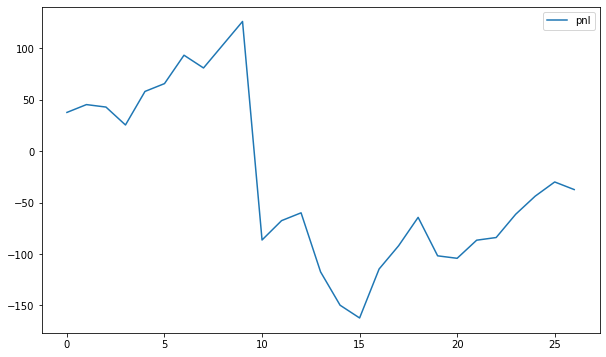

In [18]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import datetime


class cointegration_analysis:
    # init
    def __init__(self, series_A, series_B):
        self.data_A = series_A
        self.data_B = series_B
        self.coin_series = {}
        self.is_co_int = False
        self.std_value = 0
        self.beta = 1

    def ADF_check(self, check_series):
        if len(check_series) == 0:
            print("ADF CHECK 请输入正确序列！！")
            return False, []
        adf = ts.adfuller(check_series)
        if adf[1] < 0.1:  # 小于指定值，证明显著性可以通过检验
            return True, adf
        else:
            return False, adf

    def cointegration_check(self):
        # step2 使用OLS 计算残差序列，验证是否平稳
        model = sm.OLS(self.data_A, self.data_B).fit()
        self.beta = model.params[self.data_B.name]
        self.coin_series = self.data_A - (self.data_B * self.beta)
        res = self.ADF_check(self.coin_series)
        self.is_co_int = res[0]
        self.std_value = np.std(self.coin_series)
        return self.is_co_int, self.std_value

    def run(self):
        return self.cointegration_check()

    def get_result(self):
        return self.is_co_int, self.coin_series, self.std_value, self.beta

    def ecm_analysis(self):
        pass


def get_instrument_info(instrument_id, input_path):

    dir_path = os.path.join(input_path, instrument_id)
    info_file_path = os.path.join(dir_path, trading_instrument + "_info.csv")
    info_data = pd.read_csv(info_file_path, index_col=[0])
    if len(info_data) > 0:
        info_data["change_date"] = pd.to_datetime(info_data["change_date"])
        return info_data
    else:
        print("input err!!")
        return info_data


def get_trade_data(trading_date_start, trading_date_end, df_all):
    return df_all[(df_all["trading_date"] >= trading_date_start)
                  & (df_all["trading_date"] < trading_date_end)]


def get_trade_data_by_workdays(trading_date, direction, days, df_all):
    # 取出数据，包含当天数据 direction 大于0往后，小于等于0往前
    find_date = trading_date
    find_data_count = 0
    res_finding = False
    res_df = pd.DataFrame()

    for i in range(0, 60):
        if find_data_count < days:
            temp_data = df_all[(df_all["trading_date"] >= find_date) & (
                df_all["trading_date"] < (find_date + pd.Timedelta("1 day")))]

            if len(temp_data) > 10:
                find_data_count += 1
                res_df = pd.concat([res_df, temp_data])
        if direction > 0:
            find_date = find_date + pd.Timedelta("1 day")
        else:
            find_date = find_date - pd.Timedelta("1 day")

    if find_data_count >= days:
        res_finding = True
    return res_finding, find_data_count, res_df


class trading_process():
    def __init__(self,tick_size,single_trading_cost):
        #交易状态参数
        self.direction = None  # "a-b", "b-a"
        self.stop_event = "none"
        self.holding = False
        self.trading_index = 0
        self.data_size = 0
        #结果记录参数
        self.enter_record = []
        self.out_record = []
        self.pnl_res = []
        #交易参数
        self.single_cost = single_trading_cost 
        self.open_threshold = None
        self.close_threshold = None
        self.open_threshold2 = None
        self.close_threshold2 = None
        self.training_data_std = None
        self.biggest_lost = None
        self.biggest_profit = None #止盈
        self.df_orignal = pd.DataFrame()
        self.df_processed = pd.DataFrame()
        #产品信息参数
        self.tick_size = tick_size
        self.beta = 1


    def append(self, trading_df):
        self.df_orignal = pd.concat([self.df_orignal,trading_df])    
        temp = pd.DataFrame()
        temp['ask_price_eps'] = trading_df.bid_A - trading_df.ask_B * self.beta
        temp['bid_price_eps'] = trading_df.ask_A - trading_df.bid_B * self.beta
        temp['ask_price'] = trading_df.bid_A - trading_df.ask_B
        temp['bid_price'] = trading_df.ask_A - trading_df.bid_B
        temp['trading_date'] = trading_df.trading_date
        self.df_processed = pd.concat([self.df_processed,temp])
        self.data_size = len(self.df_processed)

    def set_parameters(self, spd_beta, spd_open_thro, spd_close_thro, spd_biggest_lost = None, spd_biggest_profit = None,spd_open_thro2 = None, spd_close_thro2 = None):
        self.beta = spd_beta
        self.open_threshold = spd_open_thro
        self.close_threshold = spd_close_thro
        self.open_threshold2 = spd_open_thro2
        self.close_threshold2 = spd_close_thro2
        self.biggest_lost = spd_biggest_lost
        self.biggest_profit = spd_biggest_profit

    def trading_run(self, open_enable = True):
        start_index = self.trading_index
        self.trading_index = self.data_size
        for idx in range(start_index, self.data_size):
            ask_price = self.df_processed.ask_price_eps[idx] #获取价格
            bid_price = self.df_processed.bid_price_eps[idx]
            if (self.holding == False) and (open_enable == True):
                # 判断进场条件
                if ask_price > self.open_threshold and self.stop_event != 'up_stop' :
                    self.holding = True
                    self.stop_event = "none"
                    self.direction = 'b-a'
                    #记录进场信息
                    print(self.df_processed.index[idx],'b-a进场', self.df_processed.ask_price[idx], ask_price,' count',len(self.enter_record))
                    self.enter_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx], ask_price, self.df_processed.ask_price[idx],self.direction])
                elif bid_price < -self.open_threshold and self.stop_event != 'down_stop':
                    self.holding = True
                    self.stop_event = "none"
                    self.direction = 'a-b'
                    #记录进场信息
                    print(self.df_processed.index[idx],'a-b进场', self.df_processed.bid_price[idx], bid_price,' count',len(self.enter_record))
                    self.enter_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx], bid_price, self.df_processed.bid_price[idx],self.direction])
            elif(self.holding == True):
                #出场判断，正常出场和止损出场
                # 正常离场
                if self.direction == 'a-b' and ask_price > -self.close_threshold:
                    self.holding = False
                    #计算收益
                    out_price = self.df_processed.ask_price[idx]
                    last_enter_price = self.enter_record[-1][4]
                    single_ret = (out_price - last_enter_price)
                    #判断交易日计算手续费
                    if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                        single_cost = self.single_cost
                    else:
                        single_cost = self.single_cost * 2
                    self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                    self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                            ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                    print(self.df_processed.index[idx],'a-b出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost)    
                elif self.direction =='b-a' and bid_price < self.close_threshold:
                    self.holding = False
                    #计算收益
                    out_price = self.df_processed.bid_price[idx]
                    last_enter_price = self.enter_record[-1][4]
                    single_ret = (last_enter_price - out_price)
                    #判断交易日计算手续费
                    if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                        single_cost = self.single_cost
                    else:
                        single_cost = self.single_cost * 2
                    self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                    self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                            bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                    print(self.df_processed.index[idx],'b-a出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)
                elif self.biggest_lost is not None:
                    #判断是否满足强制离场的条件-止损值
                    if self.direction == 'a-b':
                        #计算实时收益
                        out_price = self.df_processed.ask_price[idx]
                        last_enter_price = self.enter_record[-1][4]
                        single_ret = (out_price - last_enter_price)                
                        if single_ret < self.biggest_lost:
                            self.holding = False
                            self.stop_event = 'down_stop'
                            #判断交易日计算手续费
                            if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                                single_cost = self.single_cost
                            else:
                                single_cost = self.single_cost * 2
                            self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                            self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                                    ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                            print(self.df_processed.index[idx],'a-b止损出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost) 
                    elif self.direction =='b-a':
                        #计算实时收益
                        out_price = self.df_processed.bid_price[idx]
                        last_enter_price = self.enter_record[-1][4]
                        single_ret = (last_enter_price - out_price)
                        if single_ret < self.biggest_lost:
                            self.holding = False
                            self.stop_event = 'up_stop'
                            #判断交易日计算手续费
                            if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                                single_cost = self.single_cost
                            else:
                                single_cost = self.single_cost * 2
                            self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                            self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                                    bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                            print(self.df_processed.index[idx],'b-a止损出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)
                if (self.holding == True) and (self.biggest_profit is not None):
                    #判断是否满足强制离场的条件-止盈
                    if self.direction == 'a-b':
                        #计算实时收益
                        out_price = self.df_processed.ask_price[idx]
                        last_enter_price = self.enter_record[-1][4]
                        single_ret = (out_price - last_enter_price)                
                        if single_ret > self.biggest_profit:
                            self.holding = False
                            self.stop_event = 'down_stop'
                            #判断交易日计算手续费
                            if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                                single_cost = self.single_cost
                            else:
                                single_cost = self.single_cost * 2
                            self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                            self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                                    ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                            print(self.df_processed.index[idx],'a-b止盈出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost) 
                    elif self.direction =='b-a':
                        #计算实时收益
                        out_price = self.df_processed.bid_price[idx]
                        last_enter_price = self.enter_record[-1][4]
                        single_ret = (last_enter_price - out_price)
                        if single_ret > self.biggest_profit:
                            self.holding = False
                            self.stop_event = 'up_stop'
                            #判断交易日计算手续费
                            if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                                single_cost = self.single_cost
                            else:
                                single_cost = self.single_cost * 2
                            self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                            self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                                    bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                            print(self.df_processed.index[idx],'b-a止盈出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)


    def force_close(self):
        idx = self.data_size - 30 #使用收盘前半个小时的价格强制平仓
        ask_price = self.df_processed.ask_price_eps[idx] #获取价格
        bid_price = self.df_processed.bid_price_eps[idx]
        if self.holding:
            # 强制离场
            if self.direction == 'a-b':
                self.holding = False
                #计算收益
                out_price = self.df_processed.ask_price[idx]
                last_enter_price = self.enter_record[-1][4]
                single_ret = (out_price - last_enter_price)
                #判断交易日计算手续费
                if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                    single_cost = self.single_cost
                else:
                    single_cost = self.single_cost * 2
                self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])

                self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                        ask_price, self.df_processed.ask_price[idx],self.direction,single_ret,single_cost])
                print(self.df_processed.index[idx],'a-b强制出场', self.df_processed.ask_price[idx], ask_price,'ret:',single_ret - single_cost)
            elif self.direction =='b-a':
                self.holding = False
                #计算收益
                out_price = self.df_processed.bid_price[idx]
                last_enter_price = self.enter_record[-1][4]
                single_ret = (last_enter_price - out_price)
                #判断交易日计算手续费-相同交易日只付一次，不同交易日付平仓手续费
                if self.enter_record[-1][2] == self.df_processed.trading_date[idx]:
                    single_cost = self.single_cost
                else:
                    single_cost = self.single_cost * 2
                self.pnl_res.append([single_ret,single_cost,single_ret - single_cost])
                self.out_record.append([idx, self.df_processed.index[idx],self.df_processed.trading_date[idx],\
                                        bid_price, self.df_processed.bid_price[idx],self.direction,single_ret,single_cost])
                print(self.df_processed.index[idx],'b-a强制出场', self.df_processed.bid_price[idx], bid_price,'ret:',single_ret - single_cost)





def trading(start_day, end_day, df_all, trading_entity, setting):
    #交易处理函数，轮询时间，生成交易参数回测交易
    print('process:', start_day, 'to', end_day)
    trading_day = start_day
    trading_count = 0
    while trading_day <= end_day:
        if trading_count % setting['trading_delta_work_days'] == 0:
            res_find = get_trade_data_by_workdays(trading_day - pd.Timedelta("1 day"),0,setting['train_data_work_days'],df_all)
            df_train_data = res_find[2]
            #some calculate
            coin_test = cointegration_analysis(df_train_data.last_A,df_train_data.last_B)
            coin_test.run()
            res = coin_test.get_result()
            temp_std = res[2]
            temp_beta = res[3]
            open_thro = temp_std * setting['open_thro_k_std']
            close_thro = temp_std * setting['close_thro_k_std']
            #计算各种阈值，并设置到交易实体当中
            trading_entity.set_parameters(temp_beta, open_thro, close_thro, spd_biggest_lost = setting['biggest_lost'], spd_biggest_profit = setting['biggest_profit'])          

        #取出交易数据
        trading_data = get_trade_data(trading_day,
                                      trading_day + pd.Timedelta("1 day"),
                                      df_all)
        if len(trading_data) > 0:  #有数据
            trading_entity.append(trading_data)
            trading_entity.trading_run()
            trading_count += 1  #交易计数，用作更新参数计数,只有交易日才增加

        #今天数据处理完成，往后增加一天退出循环的关键。
        trading_day += pd.Timedelta("1 day")
    #根据交易的持仓情况进行最后的处理
    if trading_entity.holding == True:
        #再取几天数据进行平仓
        for j in range(0,5):
            #再最多取出5天交易数据
            trading_data = get_trade_data(trading_day,trading_day + pd.Timedelta("1 day"), df_all)
            if len(trading_data) > 0:  #有数据
                trading_entity.append(trading_data)
                trading_entity.trading_run(open_enable = False)
            trading_day += pd.Timedelta("1 day")
            if trading_entity.holding == False:
                break
        #循环结束还没有平仓，则强制平仓
        if trading_entity.holding:
            trading_entity.force_close()
    #整理交易结果

    return trading_day



if __name__ == "__main__":
    trading_instrument = "pb"
    dir_data_path = "RESULT_ALL_new"
    trade_start_date = datetime.datetime(2020, 5, 1)
    trade_end_date = datetime.datetime(2021,6, 1)
    #在这里定义交易参数：
    trading_setting = {
        'trading_delta_work_days':10,
        "train_data_work_days": 10,
        "instrument_tick_size": 5,
        "trading_cost": 1.2,
        "biggest_lost": -200,
        "biggest_profit": 50,
        "open_thro_k_std": 2,
        "close_thro_k_std": 0.1
    }

    df_info = get_instrument_info(trading_instrument, dir_data_path)
    #生成交易实例
    trading_entity = trading_process(trading_setting['instrument_tick_size'],trading_setting['trading_cost'])
    print(df_info)
    #找出交易的时段
    trading_date = trade_start_date
    #找到起始日
    if trading_date < df_info.change_date[0]:
        trading_date = df_info.change_date[0]
    for i in range(0, len(df_info) - 1):
        if trading_date >= df_info.change_date[i] and trading_date < df_info.change_date[i + 1] and trading_date < trade_end_date:
            file_path = os.path.join(dir_data_path, trading_instrument)
            data_all_path = os.path.join(file_path, df_info.a_id[i] + "_" + df_info.b_id[i] + "_final.csv")
            df_data = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
            df_data['trading_date'] = pd.to_datetime(df_data['trading_date']) #改变时间列的格式
            end_date = df_info.change_date[i + 1]
            #确保交易到设置的最后一天
            if end_date > trade_end_date:
                end_date = trade_end_date
            #输入交易时段和数据进行交易，以及交易一个主力合约的时段
            trading_date = trading(trading_date, end_date, df_data, trading_entity, trading_setting)
    #如果交易到最后一个主力合约
    if (trading_date >= df_info.change_date[len(df_info) - 1]) and (trading_date < trade_end_date):

        file_path = os.path.join(dir_data_path, trading_instrument)
        data_all_path = os.path.join(file_path, df_info.a_id[len(df_info) - 1] + "_" + df_info.b_id[len(df_info) - 1] + "_final.csv")
        df_data = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
        df_data['trading_date'] = pd.to_datetime(df_data['trading_date']) #改变时间列的格式
        end_date = df_info.change_date[len(df_info) - 1] + pd.Timedelta("60 day")
        #确保交易到设置的最后一天
        if end_date > trade_end_date:
            end_date = trade_end_date
        #输入交易时段和数据进行交易，以及交易一个主力合约的时段
        trading_date = trading(trading_date, end_date, df_data, trading_entity, trading_setting)

    #输出结果
    ret = [i[2] for i in trading_entity.pnl_res]
    print('总收益：',np.array(ret).sum())

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.plot(np.array(ret).cumsum(), label='pnl')
    plt.legend()
    plt.show()

In [2]:
trading_entity.biggest_profit

10

In [50]:
import numpy as np
import datetime

def create_assist_date(datestart = None,days = None):
    # 创建日期辅助表
    if datestart is None:
        datestart = '2016-01-01'

    # 转为日期格式
    datestart=datetime.datetime.strptime(datestart,'%Y-%m-%d')
    dateend=datestart + pd.Timedelta(f"{days - 1} day")
    date_list = []
    date_list.append(datestart.strftime('%Y-%m-%d'))
    while datestart<dateend:
        # 日期叠加一天
        datestart+=datetime.timedelta(days=+1)
        # 日期转字符串存入列表
        date_list.append(datestart.strftime('%Y-%m-%d'))
    return date_list



test_dic = {}
for i in range(0,20):
    test_df = pd.DataFrame(np.random.random((400,20)))
    test_df.index = create_assist_date('2016-01-01',400)
    test_dic[f"X{i}"] = test_df


test_dic['X0']



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2016-01-01,0.917039,0.421655,0.313660,0.353515,0.005255,0.662134,0.973654,0.796544,0.925435,0.559687,0.377145,0.803317,0.429779,0.573084,0.242753,0.026956,0.675342,0.568912,0.972344,0.137538
2016-01-02,0.736877,0.533395,0.354213,0.518489,0.070463,0.389029,0.019562,0.939393,0.694287,0.098423,0.853764,0.373778,0.215804,0.589766,0.508277,0.522323,0.320103,0.979592,0.829021,0.751385
2016-01-03,0.966916,0.230415,0.944914,0.731123,0.009307,0.979749,0.055534,0.265851,0.616299,0.905110,0.482771,0.711910,0.695404,0.092877,0.794772,0.123219,0.366510,0.489052,0.729152,0.900680
2016-01-04,0.830220,0.919902,0.230686,0.613920,0.726842,0.594615,0.954079,0.665277,0.720277,0.152352,0.508187,0.303311,0.449051,0.370887,0.327162,0.619656,0.288316,0.322765,0.383378,0.117283
2016-01-05,0.230485,0.151951,0.409189,0.513798,0.592463,0.411147,0.396506,0.538905,0.418753,0.533355,0.816256,0.808902,0.966034,0.337345,0.015405,0.189316,0.748913,0.551880,0.177157,0.338033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-30,0.119521,0.366501,0.437716,0.210688,0.975498,0.939562,0.901318,0.919930,0.708324,0.496285,0.776585,0.597267,0.345389,0.849572,0.532327,0.794219,0.293021,0.032750,0.241109,0.161015
2017-01-31,0.590865,0.675831,0.264219,0.560125,0.356002,0.937804,0.147182,0.823969,0.197259,0.973189,0.298296,0.217309,0.958332,0.374091,0.993115,0.930599,0.195412,0.368982,0.398550,0.035247
2017-02-01,0.139072,0.363392,0.141032,0.586302,0.308515,0.442110,0.580582,0.365411,0.221629,0.982327,0.220356,0.652885,0.006183,0.312031,0.056478,0.136065,0.564214,0.896764,0.212521,0.531604
2017-02-02,0.814386,0.169263,0.209769,0.667466,0.560973,0.710623,0.539495,0.251215,0.897078,0.713136,0.387454,0.007168,0.280882,0.124079,0.366140,0.098345,0.617384,0.489291,0.844003,0.819624


In [59]:

import time
s = time.time()
for k,v in test_dic.items():
    v.iloc[:, -1] = v.iloc[:, :-1].mean(axis=1)
print(time.time() - s)

0.008975028991699219


In [41]:
a['a']

,0,1
0,10000,1
